<a href="https://colab.research.google.com/github/LuciAkirami/nlp-cookbook/blob/main/NLP_1_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers[torch] datasets huggingface_hub umap-learn > /dev/null

In [2]:
!pip install

ERROR: You must give at least one requirement to install (see "pip help install")


In [3]:
# needed for training the HuggingFace Models
# !pip install accelerate transformers[torch]  > /dev/null

In [4]:
import datasets
import huggingface_hub
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import torch
import umap
import sklearn

### HuggingFace Datasets

Listing the Datasets

In [5]:
import datasets
from huggingface_hub import list_datasets

all_datasets = [dataset.id for dataset in list_datasets()]
print("Number of Datasets:",len(all_datasets))
print(all_datasets[:10])

Number of Datasets: 82991
['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


Loading a dataset

In [6]:
from datasets import load_dataset

emotion_data = load_dataset('emotion')
print(emotion_data)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


Inspecting the dataset

In [7]:
train_ds = emotion_data['train']
print(train_ds)

print("\nAccessing an element")
print(train_ds[0])

print("\nExploring features")
print(train_ds.features) # notice that the "label" is of type ClassLabel

print("\nAccessing Multiple Text with Labels")
print(train_ds[:5]) # of type dict

print("\nAccessing only multiple text")
print(train_ds['text'][:5]) # of type list

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

Accessing an element
{'text': 'i didnt feel humiliated', 'label': 0}

Exploring features
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

Accessing Multiple Text with Labels
{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}

Accessing only multiple text
['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am f

Loading Datasets that aren't present in Hugging Face
- In the below the url can be replaced with a directory path to local files
- load_dataset supports "csv", "txt" and "json"
- more on data loading https://huggingface.co/docs/datasets/loading

In [8]:
# the below file is quite similar to a csv file, hence using csv instead text
# update: the below isn't a valid url, but the process is same
# dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt?dl=1"
# emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";",
#                                names=["text", "label"])

HuggingFace Datasets to Pandas

In [9]:
emotion_data.set_format(type='pandas')
df = emotion_data['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


Fetching Label Names from HuggingFace Datasets

In [10]:
# fetching the labelnames and adding them to dataset
def label_int2struct(row):
  return emotion_data['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2struct)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Visualizations

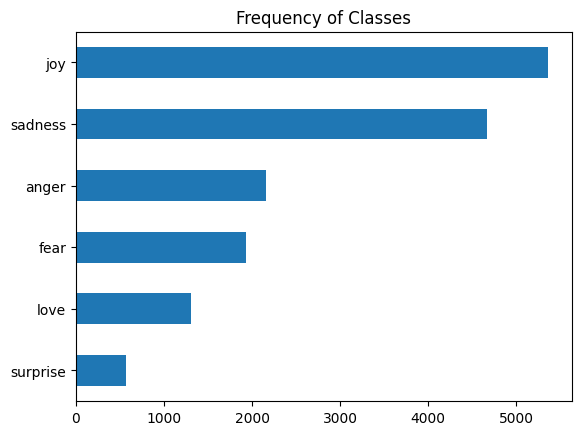

In [11]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

From above we can say that the data is imbalanced, so any of the below needs to be done

- Randomly oversample the minority class.
- Randomly undersample the majority class.
- Gather more labeled data from the underrepresented classes.
(Visit Imbalanced Learn to perform these)

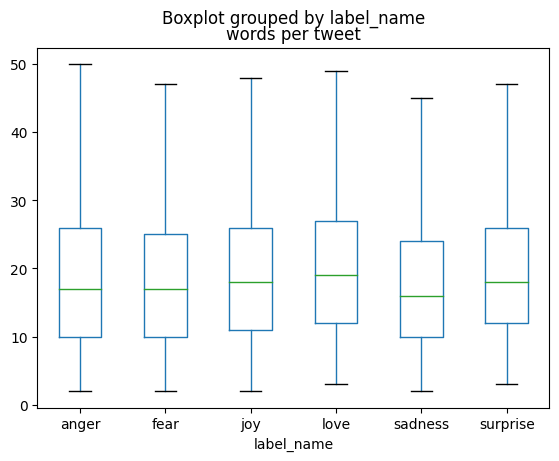

In [12]:
df['words per tweet'] = df['text'].str.split().apply(len)
df.boxplot("words per tweet",by="label_name",showfliers=False,grid=False)
plt.show()

In [13]:
# resetting the output format as we don't need the DataFrame anymore
emotion_data.reset_format()

### Tokenization

In [14]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [15]:
encoded_text = tokenizer("Tokenizing text is a core task of NLP.")
print("Encoded Text")
display(encoded_text)

print("Decoding Encoded Text")
decoded = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
display(decoded)

print("Converting Tokens to sentence")
display(tokenizer.convert_tokens_to_string(decoded)) # [CLS] and [SEP] implies start and end of token and these change from model to model

Encoded Text


{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Decoding Encoded Text


['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '.',
 '[SEP]']

Converting Tokens to sentence


'[CLS] tokenizing text is a core task of nlp. [SEP]'

Additional Tokenizer Info

In [16]:
display(tokenizer.vocab_size)
display(tokenizer.model_input_names)
display(tokenizer.model_max_length)

30522

['input_ids', 'attention_mask']

512

Tokenizing Emotion Data

In [17]:
# function to tokenize text
def tokenize(batch):
  return tokenizer(batch['text'],truncation=True,padding=True)

display(tokenize(emotion_data['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

in the above, the second text is larger than the first text, hence the first text is padded with zeros ([PAD] - 0), to get to the length of second text


Some special tokens and token ids
- [PAD] - 0
- [UNK] - 100
- [CLS] - 101
- [SEP] - 102
- [MASK] - 103

Also note that the Attention Mask has 0s where there is Padding. The Attention Mask helps the model to ignore the Padding in the input_ids, it does this by placing 0s in attention mask array in positions where there is padding in input_ids array

In [18]:
# applying tokenize on entire dataset
encoded_emotions = emotion_data.map(
    tokenize,
    batched=True,
    batch_size = None, # will tokenize entire data as a single batch
)
# tokenizing in single batch is required so that the attention masks have same
# length / shape globally

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [19]:
print(encoded_emotions['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [20]:
print(encoded_emotions['train'][:2])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'], 'label': [0, 0], 'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Training the Classifier

Two ways to go here
- Use Transfomer as feature extractor and use a classification model on top of these features to classify the emotions
- Finetune the transformer

### Transformer as Feature Extractor

In [21]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# AutoModel.from_pretrained() loads the weights of pretrained model
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [22]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [23]:
# converting tokens to pytorch tensors

text = "this is a test"
# return_tensorrs=pt returns pytorch tensors
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")
# Shape -> [Batch Size, n_tokens]

Input tensor shape: torch.Size([1, 6])


In [24]:
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [25]:
# passing the inputs to device (CPU/GPU)
# here we iterate through the dict and pass the values to device
inputs = {k:v.to(device) for k,v in inputs.items()}
inputs # the device will be changed to cuda

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [26]:
# passing the input to the model
with torch.no_grad(): # to not automatically calcuate gradients
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [27]:
display(outputs.last_hidden_state)
display(outputs.last_hidden_state.shape)
# shape - [batch_size, n_tokens, hidden_dim]

tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0')

torch.Size([1, 6, 768])

The first token in BERT is [CLS] (Classficiation) Token. When using bert for classification tasks, we are only interested in the hidden state of this first token

- For more info (https://datascience.stackexchange.com/questions/66207/what-is-purpose-of-the-cls-token-and-why-is-its-encoding-output-important)

In [28]:
# here we are only interested in the hidden state, as these are the features
outputs.last_hidden_state[:,0].size() # 0 index contains [CLS] hidden state

torch.Size([1, 768])

In [29]:
encoded_emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [30]:
# function to calculate the hidden states

def extract_hidden_states(batch):
  # load inputs to GPU
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}

  # calculate and get the last hidden state
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state

  # Return the hidden state of [CLS] as numpy array and back to cpu
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}


In [31]:
# as the model expects tensors as inputs, conver the input_ids,
# attension_masks, labels to torch format

encoded_emotions.set_format("torch",
                            ['input_ids','attention_mask','label'])

In [32]:
# apply the function to the entire dataset
# batched=True will process it in batches of 1000
hidden_emotions = encoded_emotions.map(extract_hidden_states,
                                       batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [33]:
# we can check the hidden_state column is added
hidden_emotions["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [34]:
hidden_emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

Splitting the Dataset

In [35]:
import numpy as np

X_train = np.array(hidden_emotions["train"]["hidden_state"])
X_valid = np.array(hidden_emotions["validation"]["hidden_state"])
y_train = np.array(hidden_emotions["train"]["label"])
y_valid = np.array(hidden_emotions["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Visualizing 768 High Dimensional Data using UMAP

In [36]:
import umap
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = umap.UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.234734,6.268145,0
1,-3.010606,5.936508,0
2,5.333401,2.891553,3
3,-2.393154,3.661051,2
4,-3.369331,4.015209,3


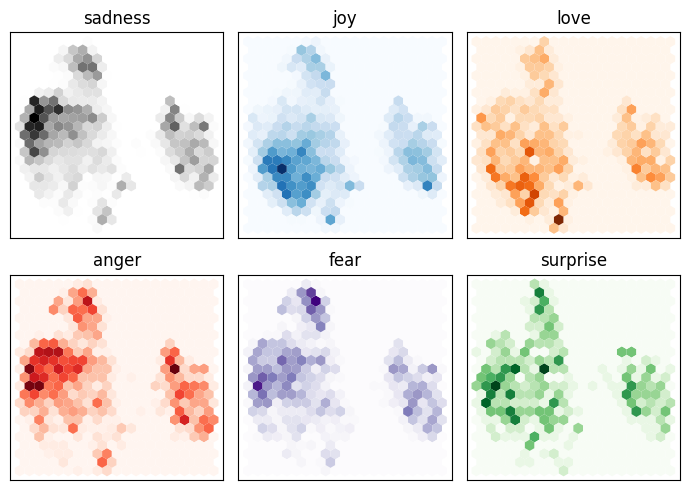

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotion_data["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

From the above plot we can check that joy and love fall in a bit similar place away from neagtive feelings and the negative feelings like sadness, anger, fear etc fall in similar place and the surprise is scattered everywhere

Training a Classifier

In [38]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=3000)
clf.fit(X_train,y_train)
clf.score(X_valid,y_valid)

0.6335

In [39]:
# checking the accuracy with a dummy classifier
from sklearn.dummy import DummyClassifier

# the below will create a dummy classifier that always
# classifies most frequent class
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

Analysis Confusion Matrix

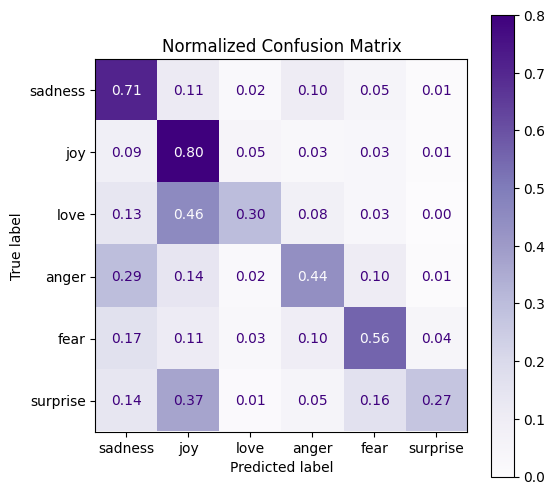

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def build_confusion_matrix_display(y_true,y_pred,label):
  cm = confusion_matrix(y_true,y_pred,normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=labels)
  disp.plot(values_format='.2f',cmap='Purples',ax=ax)
  # colorbar=False removes colorbar on rightmost of confusionmatrix
  plt.title("Normalized Confusion Matrix")
  plt.show()

y_pred = clf.predict(X_valid)
build_confusion_matrix_display(y_valid,y_pred,label)

From the above, we see that the anger and fear are most confused with sadness and love is often mistaken for joy. The same was observed when we visualized the embeddings with UMAP

### Fine-Tuning Transformers

As the above with using Transformers as feature extractors was not that accurate, the other option to consider is fine tuning the transformer model
- In using Transformers as Feature Extractors, the hidden states were fixed, as they are not trained
- In fine-tuning we train the hidden states and then train a classifier on these trained hidden states for better performance

`AutoModelForSequentialClassification` is very much similar to AutoModel, but the former also includes a classifier head on top of the pretrained model so that we can train our transformer along with the classifier
- While creating this class we pass in the number of labels so that the classifier knows how many labels to predict

In [41]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
# loading pretrained distillbert model along with a classifier head
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


It's common to get the above warning, becase the some parts of the model are randomly initialized because the classification head is not trained yet

Defininf our Metrics to Observe

In [42]:
#This function receives an EvalPrediction object (which is a named
# tuple with predictions and label_ids attributes)
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(preds,labels,average='weighted')
  acc = accuracy_score(preds,labels)

  return {"accuracy":acc,"f1 score":f1}

HuggingFace Login - To Push the Trained Model

In [43]:
from huggingface_hub import notebook_login

notebook_login()

Training the Model
- `Trainer` and `TrainingArguments` are used for training a model in huggingface
- In `TrainingArguments`  we specify all our hyper parameters

In [49]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(encoded_emotions["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  # push_to_hub=True, uncomment if wish to push
                                  log_level="error")

In [50]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_emotions["train"],
                  eval_dataset=encoded_emotions["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1 score
1,0.805200,0.302447,0.910000,0.910147
2,0.236700,0.208264,0.925000,0.925209


Getting the predictions out

In [53]:
pred_outputs_test = trainer.predict(encoded_emotions['test'])
pred_outputs_test.metrics

{'test_loss': 0.2167557328939438,
 'test_accuracy': 0.9195,
 'test_f1 score': 0.9203293225807128,
 'test_runtime': 3.8218,
 'test_samples_per_second': 523.314,
 'test_steps_per_second': 8.373}

In [54]:
pred_outputs = trainer.predict(encoded_emotions['validation'])
pred_outputs.metrics

{'test_loss': 0.2082638293504715,
 'test_accuracy': 0.925,
 'test_f1 score': 0.9252092381481191,
 'test_runtime': 3.9912,
 'test_samples_per_second': 501.106,
 'test_steps_per_second': 8.018}

In [66]:
pred_outputs.predictions # contains predictions
print('First Sentence in Validation')
print(emotion_data['validation'][0])
print('\nEncoded Version First Sentence in Validation')
print(encoded_emotions['validation'][0])
print('\nPrediction of First Sentence')
print(pred_outputs.predictions[0])
print('\nFinding the index/label with highest value')
print('Label:',np.argmax(pred_outputs.predictions[0]))

# getting the label(i.e. index with highest value) for all predictions
y_pred = np.argmax(pred_outputs.predictions,axis=1)
print("\nPredicted Labels")
y_pred

First Sentence in Validation
{'text': 'im feeling quite sad and sorry for myself but ill snap out of it soon', 'label': 0}

Encoded Version First Sentence in Validation
{'label': tensor(0), 'input_ids': tensor([  101, 10047,  3110,  3243,  6517,  1998,  3374,  2005,  2870,  2021,
         5665, 10245,  2041,  1997,  2009,  2574,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

Pred

array([0, 0, 2, ..., 1, 1, 1])

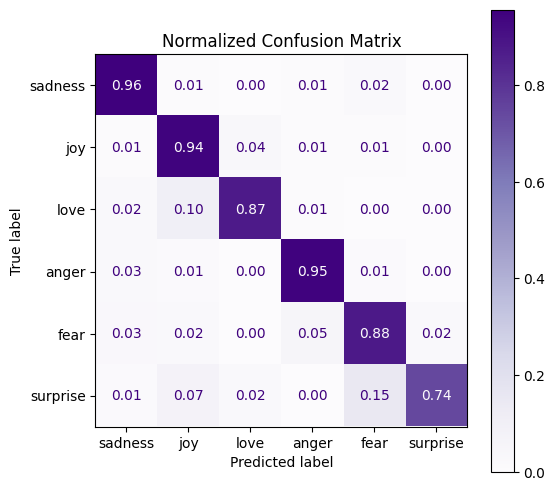

In [68]:
build_confusion_matrix_display(y_valid,y_pred,label)

The love category is still confused with joy and the surprise label is still being interpreted as joy and fear

Error Analysis
- calculating the loss for each text input
- by doing the above, we can sort the dataframe by loss

Doing the Error Analysis, we may detect the following
- Wrong labels: There maybe a chance that the annotations are wrong
- Quirks of Dataset: Real world data is always messy and dealing with textual data is messy. So by finding the examples that have high loss, we can either remove the data, or add more similar data for the model to learn

In [69]:
from torch.nn.functional import cross_entropy

# creating a function that does a forward pass
# and calculates loss for each row(each text) in our dataset
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

map vs apply
- map: takes a func and creates a new column by taking in the entire dataset/dataframe
- apply: takes a func and modifies the column on which it's called on

In [72]:
# Convert our dataset back to PyTorch tensors
encoded_emotions.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values and doing that will create two cols
# i.e. predicted_label and loss
encoded_emotions["validation"] = encoded_emotions["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [77]:
encoded_emotions.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]

# copying all the above defined columns from validation data
df_test = encoded_emotions["validation"][:][cols]

# converting the numerical labels to actual labels by using the function
# we have defined
df_test["label"] = df_test["label"].apply(label_int2struct)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2struct))

df_test.head()

,text,label,predicted_label,loss
0,im feeling quite sad and sorry for myself but ...,sadness,sadness,0.020194
1,i feel like i am still looking at a blank canv...,sadness,sadness,0.024299
2,i feel like a faithful servant,love,love,0.413868
3,i am just feeling cranky and blue,anger,anger,0.041020
4,i can have for a treat or if i am feeling festive,joy,joy,0.020201


In [78]:
# sorting the dataframe based on loss

df_test.sort_values('loss',ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.343087
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.065816
1801,i feel that he was being overshadowed by the s...,love,sadness,5.026207
1950,i as representative of everything thats wrong ...,surprise,sadness,4.998796
1111,im lazy my characters fall into categories of ...,joy,fear,4.913177
177,im sure much of the advantage is psychological...,sadness,joy,4.905988
882,i feel badly about reneging on my commitment t...,love,sadness,4.900581
1509,i guess this is a memoir so it feels like that...,joy,fear,4.769590
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.694463
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.518258


Here the model has predicted some labels incorrectly. But we also observe the data was also mislabelled. The joy label is mislabelled many a times. With this info, we can further refine the dataset thus improving the performance of the model

Taking a look at the label/class which the model is so confident of predicting

In [82]:
# checking the predictions with least losses

df_test.sort_values('loss',ascending=True).head(15)

,text,label,predicted_label,loss
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.017279
1873,i feel practically virtuous this month i have ...,joy,joy,0.017331
1528,i am feeling a little happy with him,joy,joy,0.017457
530,i feel pretty safe but i do realize that we do...,joy,joy,0.017525
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.017558
1310,i feel like an ungrateful asshole,sadness,sadness,0.017646
1601,i feel so ungrateful when thinking saying thes...,sadness,sadness,0.017686
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.017704
11,i was dribbling on mums coffee table looking o...,joy,joy,0.017761
1502,i feel ungrateful for stupid shit like,sadness,sadness,0.017783


We see that the model predicts the label sadness more confidently then all other labels. So this might be the reason for so many sadness labels in the wrong predictions

## Saving and Sharing the Model

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

In [ ]:
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [ ]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

In [ ]:
# plotting the score assigned to different labels
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()